In [27]:
import pandas as pd
import networkx as nx
import numpy as np

In [28]:
author_df = pd.read_csv('databank_deposit_version_2/salt_cont_author.csv')
report_df = pd.read_csv('databank_deposit_version_2/report_list.csv')

In [29]:
report_df.head(5)

,ID,short_name,type,study_groupings,title,year,attitude,doi,retracted(Y/N),study_design
0,1,Hooper2002,Systematic Review Report,NaN,Systematic review of long term effects of advi...,2002,inconclusive,10.1136/bmj.325.7365.628,N,Systematic Review
1,2,Hooper2003,Systematic Review Report,NaN,Reduced dietary salt for prevention of cardiov...,2003,inconclusive,10.1002/14651858.CD003656,N,Systematic Review
2,3,Hooper2004,Systematic Review Report,NaN,Advice to reduce dietary salt for prevention o...,2004,inconclusive,10.1002/14651858.CD003656.pub2,N,Systematic Review
3,4,Strazzullo2009,Systematic Review Report,NaN,"Salt intake, stroke, and cardiovascular diseas...",2009,for,10.1136/bmj.b4567,N,Systematic Review
4,5,Taylor2011a,Systematic Review Report,NaN,Reduced dietary salt for the prevention of car...,2011,inconclusive,10.1038/ajh.2011.115,N,Systematic Review


In [30]:
# extract the ids of systematic review report (SRR)
srr_id_list = report_df.loc[report_df['type'] == "Systematic Review Report"]['ID'].to_list()

In [31]:
# extract the ids of primary study reports (PSRs)
psr_id_list = report_df.loc[report_df['type'] == "Primary Study Report"]['ID'].to_list()

In [32]:
# create an author dictionary
author_df['author_full_name'] = author_df['author_given_name'] + ' ' + author_df['author_surname']
author_info = author_df[['author_id', 'author_full_name']].groupby('author_id').aggregate('max')
author_id = author_info.index.to_list()
author_name = author_info['author_full_name'].to_list()
author_dict = {author_id[i]:author_name[i] for i in range(len(author_id))}

In [33]:
# adding to author_info dataframe with the number of SRRs and PSRs authored, and compute the percentage of SRRs
author_info = author_df[['author_id', 'report_id']].groupby('author_id')['report_id'].apply(list)
author_info = pd.DataFrame(author_info)
author_info['no_of_srrs'] = author_info['report_id'].apply(lambda x: sum([y in srr_id_list for y in x]))
author_info['no_of_psrs'] = author_info['report_id'].apply(lambda x: sum([y in psr_id_list for y in x]))
author_info['percent_srrs'] = author_info['no_of_srrs'] / (author_info['no_of_srrs'] + author_info['no_of_psrs'])
author_info['author_full_name'] = [author_dict[idx] for idx in author_info.index]
author_info['author_full_name'] = [author_dict[idx] for idx in author_info.index]

In [34]:
# create a report dictionary
report_info = report_df[['ID', 'short_name']]
report_id = report_info['ID'].to_list()
report_name = report_info['short_name'].to_list()
report_dict = {report_id[i]:report_name[i] for i in range(len(report_id))}

In [35]:
# edge_list
report_node_set = author_df['report_id'].to_list()
author_node_set = author_df['author_id'].to_list()
edge_list = [(report_node_set[i], author_node_set[i]) for i in range(len(report_node_set))]

In [36]:
# create two co-author matrix, one for SRRs and one for PSRs

# create blank a matrix (author(row names) * report (column names))
srr_df = pd.DataFrame(np.zeros((len(author_id), len(report_id))),
                 columns=report_id,
                 index=author_id)

psr_df = pd.DataFrame(np.zeros((len(author_id), len(report_id))),
                      columns=report_id,
                      index=author_id)


# create the author * report matrix
for i in range(len(edge_list)):
    if edge_list[i][0] in srr_id_list:
        row_index = edge_list[i][1]
        column_index = edge_list[i][0]
        srr_df[column_index][row_index] = 1
    elif edge_list[i][0] in psr_id_list:
        row_index = edge_list[i][1]
        column_index = edge_list[i][0]
        psr_df[column_index][row_index] = 1

# using matrix algebra to create the co-author network, weight is the nature of collaboration (100% review to 0% review)
srr_coauthor_adj_mat = np.matrix(srr_df)*np.matrix(srr_df).transpose()
psr_coauthor_adj_mat = np.matrix(psr_df)*np.matrix(psr_df).transpose()

# create two edgelists
srr_coauthor_adj_mat = pd.DataFrame(srr_coauthor_adj_mat, columns=author_id, index=author_id)
psr_coauthor_adj_mat = pd.DataFrame(psr_coauthor_adj_mat, columns=author_id, index=author_id)
srr_edgelist_df = pd.DataFrame(srr_coauthor_adj_mat.stack().reset_index()).rename(columns={'level_0': 'source', 'level_1':'target', 0:'no_of_srrs_coauthored'})
psr_edgelist_df = pd.DataFrame(psr_coauthor_adj_mat.stack().reset_index()).rename(columns={'level_0': 'source', 'level_1':'target', 0:'no_of_psrs_coauthored'})

In [37]:
srr_edgelist_df[srr_edgelist_df['no_of_srrs_coauthored'] != 0]

,source,target,no_of_srrs_coauthored
610,3,3,1.0
611,3,4,1.0
915,3,7006484941,1.0
1159,3,55628530729,1.0
1219,4,3,1.0
...,...,...,...
367220,57209290036,57209290036,1.0
369446,57222968090,8637630800,1.0
369587,57222968090,55260676500,1.0
369628,57222968090,56539588600,1.0


In [38]:
# create a matrix (author(row names) * report (column names))
author_report_df = pd.DataFrame(np.zeros((len(author_id), len(report_id))),
                 columns=report_id,
                 index=author_id)

for i in range(len(edge_list)):
    row_index = edge_list[i][1]
    column_index = edge_list[i][0]
    author_report_df[column_index][row_index] = 1

# using matrix algebra to create the co-author network
coauthor_mat = np.matrix(author_report_df)*np.matrix(author_report_df).transpose()

# create a new df to hold the adjacency matrix
coauthor_adj_mat = pd.DataFrame(coauthor_mat, columns=author_id, index=author_id)
total_edgelist_df = pd.DataFrame(coauthor_adj_mat.stack().reset_index()).rename(columns={'level_0': 'source', 'level_1':'target', 0:'no_of_reports_coauthored'})

In [39]:
srr_edgelist_df.head(5)

,source,target,no_of_srrs_coauthored
0,1,1,0.0
1,1,3,0.0
2,1,4,0.0
3,1,5,0.0
4,1,6,0.0


In [40]:
psr_edgelist_df.head(5)

,source,target,no_of_psrs_coauthored
0,1,1,4.0
1,1,3,0.0
2,1,4,0.0
3,1,5,1.0
4,1,6,2.0


In [41]:
total_edgelist_df.head(5)

,source,target,no_of_reports_coauthored
0,1,1,4.0
1,1,3,0.0
2,1,4,0.0
3,1,5,1.0
4,1,6,2.0


In [42]:
# merge the three dataframes
edgelist_df = total_edgelist_df.merge(right=srr_edgelist_df, on=['source', 'target']).merge(right=psr_edgelist_df, on=['source', 'target'])
edgelist_df.head(5)

,source,target,no_of_reports_coauthored,no_of_srrs_coauthored,no_of_psrs_coauthored
0,1,1,4.0,0.0,4.0
1,1,3,0.0,0.0,0.0
2,1,4,0.0,0.0,0.0
3,1,5,1.0,0.0,1.0
4,1,6,2.0,0.0,2.0


In [43]:
# trim off the entries where no_of_reports_coauthored == 0
edgelist_df = edgelist_df[edgelist_df['no_of_reports_coauthored'] != 0]
edgelist_df.shape

(26423, 5)

In [44]:
# trim off self loop (source == target)
edgelist_df = edgelist_df[edgelist_df['source'] != edgelist_df['target']]
edgelist_df.shape

(25814, 5)

In [45]:
edgelist_df.head(5)

,source,target,no_of_reports_coauthored,no_of_srrs_coauthored,no_of_psrs_coauthored
3,1,5,1.0,0.0,1.0
4,1,6,2.0,0.0,2.0
5,1,7,2.0,0.0,2.0
14,1,16,1.0,0.0,1.0
16,1,18,1.0,0.0,1.0


In [46]:
# compute percentage
edgelist_df['percent_srrs'] = edgelist_df['no_of_srrs_coauthored']/edgelist_df['no_of_reports_coauthored']
edgelist_df.head(5)

,source,target,no_of_reports_coauthored,no_of_srrs_coauthored,no_of_psrs_coauthored,percent_srrs
3,1,5,1.0,0.0,1.0,0.0
4,1,6,2.0,0.0,2.0,0.0
5,1,7,2.0,0.0,2.0,0.0
14,1,16,1.0,0.0,1.0,0.0
16,1,18,1.0,0.0,1.0,0.0


<AxesSubplot:>

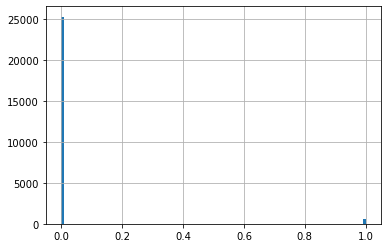

In [47]:
# visualize histogram of the percent_srrs among edges
edgelist_df['percent_srrs'].hist(bins=100)

In [48]:
author_info.head(5)

,report_id,no_of_srrs,no_of_psrs,percent_srrs,author_full_name
author_id,,,,,
1,"[35, 36, 37, 32]",0,4,0.0,Jerome D. Cohen
3,[10],1,0,1.0,JJ DiNicolantonio
4,[10],1,0,1.0,DG Hackam
5,"[32, 38]",0,2,0.0,Jeanne Charleston
6,"[35, 37]",0,2,0.0,Jeremiah Stamler


<AxesSubplot:>

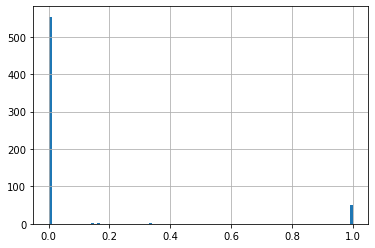

In [50]:
# visualize histogram of the percent_srr among articles
author_info['percent_srrs'].hist(bins=100)

In [51]:
# pacakge data for visualization
edgelist_df.to_csv("salt_coauthor_network_edgelist.csv", index=False)
author_info.to_csv("salt_coauthor_network_attribute_list.csv", index=True)